In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature


from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/lund_1024' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/lund_1024/cfg_args
Config file found: ./output/lund_1024/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 1196/1196
✅ Loaded 1196 cameras for this GPU (start_idx=0, end_idx=None)
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    scale_path = os.path.join(dataset.source_path, 'mask_scales', cam.image_name + '.pt')
    scales = torch.load(scale_path)
    all_scales.append(scales)

all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

18.245272 ?


In [5]:
all_scales.max()

tensor(18.2453, grad_fn=<MaxBackward1>)

In [6]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [7]:
upper_bound_scale

18.245271682739258

In [8]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [9]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 1196 views in the dataset.
18.245271682739258


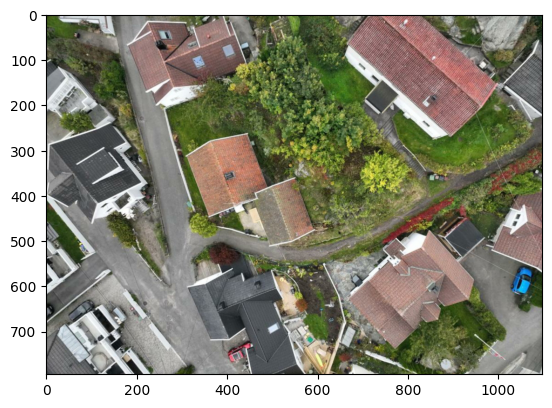

In [10]:
ref_img_camera_id = 17
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29415864..0.44591436].


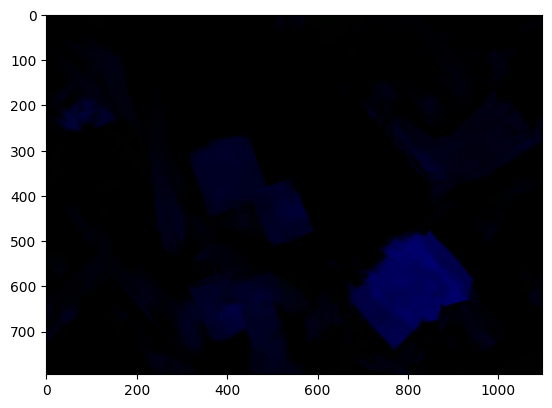

In [11]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.5]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

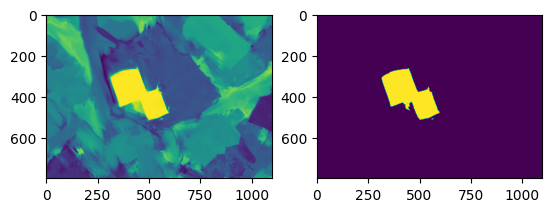

In [12]:
query_index = (300, 400)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

In [13]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

In [14]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [15]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107]


In [16]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

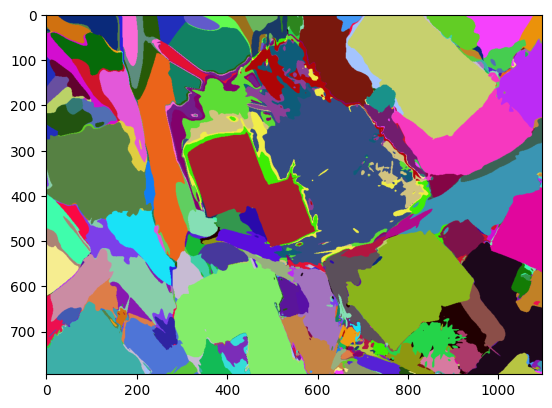

In [17]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [18]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


In [19]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.3] = 0

In [20]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[17], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

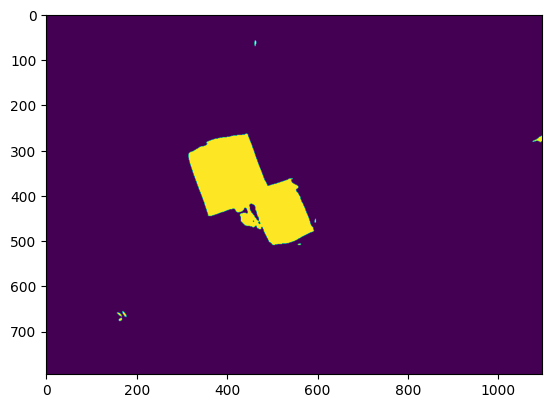

In [21]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [22]:
'''try:
    scene_gaussians.roll_back()
except:
    pass'''
scene_gaussians.segment(similarities > 0.48)

In [23]:
# save the segmentation
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.48, f'./segmentation_res/{name}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00061200873..1.4891292].


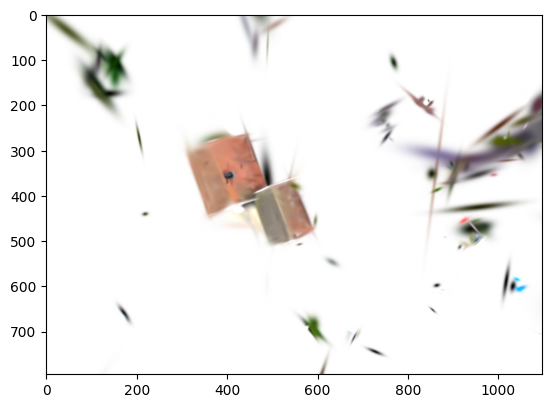

In [24]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

In [25]:
scene_gaussians.roll_back()

# Cluster in 3D

In [26]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

20341


In [27]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=80, cluster_selection_epsilon=0.1)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [28]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [29]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [30]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [31]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[17], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

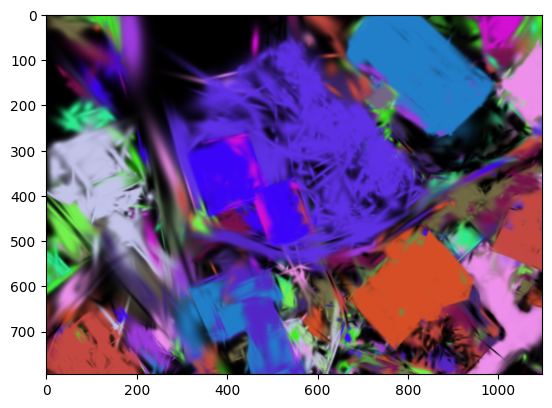

In [32]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

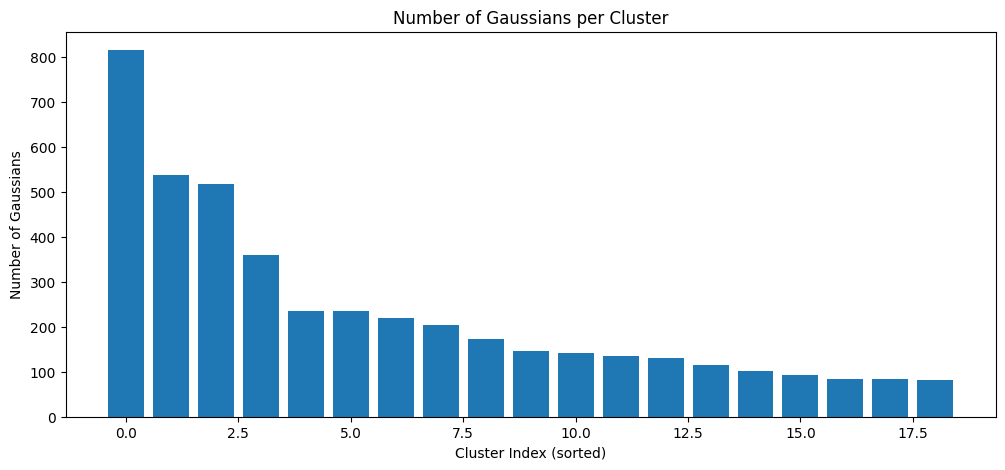

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Count how many points are in each cluster
labels = cluster_labels  # already computed from HDBSCAN
unique_labels, counts = np.unique(labels, return_counts=True)

# Skip noise (-1), if needed
valid = unique_labels != -1
unique_labels = unique_labels[valid]
counts = counts[valid]

# Sort by size (optional)
sorted_indices = np.argsort(-counts)
sorted_labels = unique_labels[sorted_indices]
sorted_counts = counts[sorted_indices]

# Plot
plt.figure(figsize=(12,5))
plt.bar(range(len(sorted_counts)), sorted_counts)
plt.xlabel("Cluster Index (sorted)")
plt.ylabel("Number of Gaussians")
plt.title("Number of Gaussians per Cluster")
plt.show()


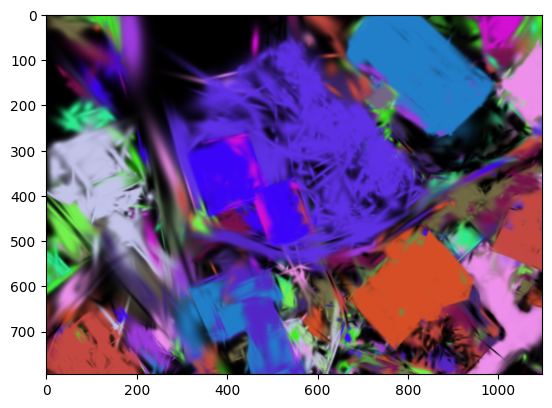

In [34]:
#matplotlib notebook  # Use this only in a notebook, not a script
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
img = rendered_seg_map.permute([1, 2, 0]).detach().cpu().numpy()
ax.imshow(img)

def onclick(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside image
    x = int(event.xdata)
    y = int(event.ydata)
    print(f"Clicked at: (x={x}, y={y})")

    # Compute flat index for cluster_labels if it's 1D
    idx = y * img.shape[1] + x
    cluster_id = cluster_labels[idx]
    print(f"Cluster ID at that point: {cluster_id.item()}")

cid = fig.canvas.mpl_connect('button_press_event', onclick)


# Global CLIP Score Sweep + Rendering + Saving


In [35]:
import torch
import os
import copy
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ✅ Make sure this is defined earlier in the notebook:
# - scene_gaussians loaded via `Scene(...)`
# - seg_score is computed
# - cameras, args, pipeline already defined

# Step 0: Extract clip scores and cache original
clip_scores = seg_score.max(dim=-1)[0]             # [N]
original_scene = copy.deepcopy(scene_gaussians)    # Full backup once
xyz_full = original_scene.get_xyz.detach()         # Save xyz for filtering

# Output settings
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70,0.75,0.80,0.85,0.90]
output_dir = './segmentation_res/global_threshold_sweep'
os.makedirs(output_dir, exist_ok=True)

# Helper: remove sparse points
def filter_sparse_regions(xyz, mask, min_neighbors=6, radius=0.06):
    coords = xyz[mask].cpu().numpy()
    nn = NearestNeighbors(radius=radius).fit(coords)
    neighbors = nn.radius_neighbors(coords, return_distance=False)
    keep_mask = torch.tensor([len(n) > min_neighbors for n in neighbors],
                             dtype=torch.bool, device=mask.device)

    filtered = torch.zeros_like(mask)
    filtered[mask] = keep_mask
    return filtered

# Sweep loop
for thresh in thresholds:
    print(f"\n🚧 Threshold: {thresh:.2f}")
    
    # Step 1: Global threshold
    mask = clip_scores > thresh
    print(f"  Kept: {mask.sum().item()} / {len(mask)}")

    # Step 2: Remove isolated points
    #mask = filter_sparse_regions(xyz_full, mask)
    mask = filter_sparse_regions(xyz_full, mask, min_neighbors=8, radius=0.12)

    # Step 3: Clone full model and segment in-place
    scene_gaussians = copy.deepcopy(original_scene)
    scene_gaussians.segment(mask)  # ⚠️ DO NOT assign, this is in-place

    # Step 4: Render
    background = torch.zeros(3, dtype=torch.float32, device="cuda")
    rendered = render(cameras[17], scene_gaussians, pipeline.extract(args),
                      background, override_color=None)['render']
    
    img_np = rendered.permute(1, 2, 0).detach().cpu().numpy()

    # Step 5: Save
    image_path = f"{output_dir}/seg_thresh_{thresh:.2f}.png"
    mask_path = f"{output_dir}/mask_thresh_{thresh:.2f}.pt"
    plt.imsave(image_path, img_np.clip(0.0, 1.0))

    torch.save(mask.cpu(), mask_path)
    print(f"  ✅ Saved: {image_path}")

print("\n🎯 Sweep complete. Check the images in:", output_dir)



🚧 Threshold: 0.50
  Kept: 875721 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.50.png

🚧 Threshold: 0.55
  Kept: 792383 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.55.png

🚧 Threshold: 0.60
  Kept: 690094 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.60.png

🚧 Threshold: 0.65
  Kept: 576323 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.65.png

🚧 Threshold: 0.70
  Kept: 463220 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.70.png

🚧 Threshold: 0.75
  Kept: 362906 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.75.png

🚧 Threshold: 0.80
  Kept: 284821 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.80.png

🚧 Threshold: 0.85
  Kept: 227661 / 1007732
  ✅ Saved: ./segmentation_res/global_threshold_sweep/seg_thresh_0.85.png

🚧 Threshold: 0.90
  Kept: 186624 / 1007732
  ✅ Saved: ./segment

# Clip features with 3d cluster check adaptive


In [36]:
import torch
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import torch
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def adaptive_segmentation_v2(
    cluster_labels,
    clip_scores,
    point_xyz=None,
    percentile_thresh=(50, 80),
    clip_thresholds=(0.60, 0.70, 0.80),
    knn_smoothing=False,
    knn_k=8,
    min_fraction_pass=0.75,
    fallback_topk=False  # 👈 NEW FLAG
):
    """
    Adaptive CLIP-based segmentation with fallback top-k retention for borderline clusters.
    """
    if isinstance(cluster_labels, torch.Tensor):
        cluster_labels = cluster_labels.cpu().numpy()

    scores = clip_scores.detach().cpu()
    sizes = Counter(cluster_labels)
    thresholds = {}
    final_mask = torch.zeros_like(scores, dtype=torch.bool)

    size_vals = np.array(list(sizes.values()))
    q1, q2 = np.percentile(size_vals, percentile_thresh)
    from sklearn.neighbors import NearestNeighbors

    

    def get_thresh(size):
        if size < q1:
            return clip_thresholds[0]
        elif size < q2:
            return clip_thresholds[1]
        else:
            return clip_thresholds[2]

    print("\n📊 Adaptive Thresholds Used:")
    for cid in np.unique(cluster_labels):
        if cid == -1:
            continue
        mask = (cluster_labels == cid)
        size = sizes[cid]
        thresh = get_thresh(size)
        thresholds[cid] = thresh

        cluster_scores = scores[mask]
        passed = cluster_scores > thresh
        fraction = passed.sum().item() / mask.sum()

        idx_mask = torch.where(torch.tensor(mask))[0]

        if fraction > min_fraction_pass:
            final_mask[idx_mask] = passed
        elif fallback_topk:
            # ✅ Retain top-k fraction even if the cluster fails
            k = int(min_fraction_pass * mask.sum().item())
            if k > 0:
                topk_indices = cluster_scores.topk(k).indices
                final_mask[idx_mask[topk_indices]] = True

        print(f"  Cluster {cid:2d} → Size: {size:5d}, Threshold: {thresh:.2f}, "
              f"Passed: {passed.sum().item():5d}, Fraction: {fraction:.2%}")

    if knn_smoothing and point_xyz is not None:
        print("\n🔄 Applying kNN smoothing...")
        xyz_np = point_xyz.detach().cpu().numpy()
        labels = final_mask.int().cpu().numpy()
        nn = NearestNeighbors(n_neighbors=knn_k).fit(xyz_np)
        _, indices = nn.kneighbors(xyz_np)
        smooth_mask = torch.zeros_like(final_mask)
        for i in range(len(labels)):
            neighbors = torch.tensor(labels[indices[i]])
            smooth_mask[i] = torch.mode(neighbors).values
        final_mask = smooth_mask.bool()

    print("\n✅ Final Mask Summary:")
    print("  Shape:", final_mask.shape)
    print("  Total Kept:", final_mask.sum().item(), "/", final_mask.shape[0])
    print("  Unique values:", torch.unique(final_mask))

    plt.hist(scores.numpy(), bins=100)
    plt.title("CLIP Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Point Count")
    plt.grid(True)
    plt.show()

    return final_mask


In [37]:
def filter_sparse_regions(xyz, mask, min_neighbors=5, radius=0.07):
        coords = xyz[mask].detach().cpu().numpy()
        nn = NearestNeighbors(radius=radius).fit(coords)
        neighbors = nn.radius_neighbors(coords, return_distance=False)
        keep_mask = torch.tensor([len(n) > min_neighbors for n in neighbors], dtype=torch.bool, device=mask.device)
    
        filtered_mask = torch.zeros_like(mask)
        filtered_mask[mask] = keep_mask
        return filtered_mask

In [38]:
# Step 1: Get cluster labels per point
labels = seg_score.argmax(dim=-1).cpu()  # shape [N]
scores = seg_score.max(dim=-1)[0].cpu()  # shape [N]

# Step 2: Run adaptive thresholding
final_mask = adaptive_segmentation_v2(
    cluster_labels=seg_score.argmax(dim=-1),
    clip_scores=seg_score.max(dim=-1)[0],
    point_xyz=scene_gaussians.get_xyz,
    clip_thresholds=(0.55, 0.65, 0.75),
    min_fraction_pass=0.6,
    knn_smoothing=True,
    fallback_topk=True  # 👈 keep strong parts of weaker clusters
)
print("final_mask:", final_mask.shape)
print("num_gaussians:", scene_gaussians.get_xyz.shape[0])
final_mask = filter_sparse_regions(scene_gaussians.get_xyz, final_mask)
print("final_mask after pruning:", final_mask.shape)
print("num_gaussians after pruning:", scene_gaussians.get_xyz.shape[0])
# ✅ Apply the mask to segment the scene
scene_gaussians = scene_gaussians.segment(final_mask)  # ✅ safer


# ✅ Save only the mask, not the whole scene_gaussians object
torch.save(final_mask.cpu(), './segmentation_res/clip_adaptive_thresh_segment.pt')

# Step 3: Assign colors (only for selected points)
labels_np = labels.numpy()
label_to_color = np.random.rand(1000, 3)
point_colors = np.zeros((len(labels_np), 3))
for i in range(len(labels_np)):
    if final_mask[i]:
        point_colors[i] = label_to_color[labels_np[i]]
    else:
        point_colors[i] = (0, 0, 0)  # background



📊 Adaptive Thresholds Used:
  Cluster  0 → Size: 41373, Threshold: 0.55, Passed: 31111, Fraction: 75.20%
  Cluster  1 → Size: 31068, Threshold: 0.55, Passed: 22945, Fraction: 73.85%
  Cluster  2 → Size: 37673, Threshold: 0.55, Passed: 31198, Fraction: 82.81%
  Cluster  3 → Size: 37040, Threshold: 0.55, Passed: 31090, Fraction: 83.94%
  Cluster  4 → Size: 76186, Threshold: 0.75, Passed: 35084, Fraction: 46.05%
  Cluster  5 → Size: 78350, Threshold: 0.75, Passed: 44972, Fraction: 57.40%
  Cluster  6 → Size: 44507, Threshold: 0.55, Passed: 32819, Fraction: 73.74%
  Cluster  7 → Size: 38453, Threshold: 0.55, Passed: 29952, Fraction: 77.89%
  Cluster  8 → Size: 63163, Threshold: 0.65, Passed: 29271, Fraction: 46.34%
  Cluster  9 → Size: 42495, Threshold: 0.55, Passed: 31453, Fraction: 74.02%
  Cluster 10 → Size: 42970, Threshold: 0.55, Passed: 34711, Fraction: 80.78%
  Cluster 11 → Size: 63394, Threshold: 0.65, Passed: 38290, Fraction: 60.40%
  Cluster 12 → Size: 47781, Threshold: 0.65, Pa

IndexError: index 184712 is out of bounds for axis 0 with size 184712

In [ ]:
from collections import Counter
import numpy as np

# seg_score: [num_points, num_clusters]
predicted_labels = seg_score.argmax(dim=-1).cpu().numpy()

# Final mask after thresholding (BoolTensor)
final_mask_np = final_mask.cpu().numpy()

# Total points per cluster (before thresholding)
cluster_counts_total = Counter(predicted_labels)

# Points per cluster that passed CLIP threshold
cluster_counts_kept = Counter(predicted_labels[final_mask_np])

print("\n📊 Final Cluster Coverage (on full point cloud):")
for cluster_id in sorted(cluster_counts_total.keys()):
    total = cluster_counts_total[cluster_id]
    kept = cluster_counts_kept.get(cluster_id, 0)
    print(f"  Cluster {cluster_id:2d} → Total: {total:5d}, Kept after threshold: {kept:5d}, Kept %: {kept / total:.2%}")


In [ ]:
try:
    scene_gaussians.roll_back()
except:
    pass

# Clip features with 3d cluster #My changes

In [ ]:
unique_labels = torch.unique(seg_score.argmax(dim=-1))  # [num_clusters]
normed_point_features = torch.nn.functional.normalize(feature_gaussians.get_point_features, dim=-1, p=2)

cluster_features = []
for label in unique_labels:
    mask = (seg_score.argmax(dim=-1) == label)
    cluster_feat = normed_point_features[mask].mean(dim=0)
    cluster_feat = torch.nn.functional.normalize(cluster_feat, dim=0, p=2)
    cluster_features.append(cluster_feat)

cluster_features = torch.stack(cluster_features).cuda()  # [num_clusters, F]


In [ ]:
import clip
import torch

def load_clip():
    model, _ = clip.load("ViT-B/32", device="cuda")
    return model

def encode_text(model, text):
    tokens = clip.tokenize([text]).cuda()
    with torch.no_grad():
        return model.encode_text(tokens).squeeze(0)
clip_model = load_clip().eval()
text_feat = encode_text(clip_model, "house").cuda()
text_feat = torch.nn.functional.normalize(text_feat, dim=0, p=2)


In [ ]:
projection = torch.nn.Linear(512, 32).cuda()
text_feat_projected = projection(text_feat.float().unsqueeze(0)).squeeze(0)
text_feat_projected = torch.nn.functional.normalize(text_feat_projected, dim=0, p=2)

clip_scores = torch.einsum('cf,f->c', cluster_features, text_feat_projected)

top_k = 5  # or adjust based on how many clusters you want
topk_indices = torch.topk(clip_scores, k=top_k).indices
print("Top matching cluster indices:", topk_indices)

selected_mask = torch.zeros_like(seg_score.argmax(dim=-1), dtype=torch.bool)
for idx in topk_indices:
    selected_mask |= (seg_score.argmax(dim=-1) == unique_labels[idx])



In [ ]:
#selected_mask = (seg_score.argmax(dim=-1) == best_label)
scene_gaussians.segment(selected_mask)
torch.save(selected_mask, './segmentation_res/clip_guided_cluster_segment.pt')


In [ ]:
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered.permute(1, 2, 0).detach().cpu())


# Language-driven Segmentation

In [ ]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

In [ ]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        #sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.load(view.original_masks).cuda().unsqueeze(1)
        
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        #mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = torch.load(view.mask_scales).cuda().unsqueeze(-1)
        
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        #scales.append(view.mask_scales.cuda().unsqueeze(-1))
        scales.append(torch.load(view.mask_scales).cuda().unsqueeze(-1))
        

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()

In [ ]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
#flattened_clip_features = torch.cat(clip_features, dim = 0)
clip_features = [torch.load(path).cuda() for path in clip_features]
flattened_clip_features = torch.cat(clip_features, dim=0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

In [ ]:
import umap
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Step 1: Optional PCA to 64D
features = flattened_clip_features.cpu().numpy()
features = PCA(n_components=64).fit_transform(features)

# Step 2: UMAP to 2D (for visualization) and 32D (for clustering)
print("🔄 Running UMAP...")
reducer_for_clustering = umap.UMAP(n_components=32, metric='cosine', n_neighbors=50, min_dist=0.3, random_state=42)
features_umap_32d = reducer_for_clustering.fit_transform(features)

# For 2D visualization
reducer_for_plot = umap.UMAP(n_components=2, metric='cosine', n_neighbors=50, min_dist=0.3, random_state=42)
features_umap_2d = reducer_for_plot.fit_transform(features)

# Step 3: HDBSCAN
print("🔍 Clustering with HDBSCAN (min_cluster_size=50, min_samples=10)...")
clusterer = HDBSCAN(min_cluster_size=50, min_samples=10, metric='euclidean')
cluster_labels = clusterer.fit_predict(features_umap_32d)

# Step 4: To torch
cluster_labels = torch.from_numpy(cluster_labels).to(flattened_clip_features.device)
n_clusters = len(torch.unique(cluster_labels[cluster_labels != -1]))
print(f"✅ Found {n_clusters} clusters (excluding noise)")

# Step 5: Visualize
plt.figure(figsize=(10, 8))
palette = plt.get_cmap("tab20")
for label in set(cluster_labels.cpu().numpy()):
    mask = cluster_labels.cpu().numpy() == label
    plt.scatter(features_umap_2d[mask, 0], features_umap_2d[mask, 1], 
                s=10, label=f"Cluster {label}" if label != -1 else "Noise", 
                alpha=0.6, c=[palette(label % 20)] * mask.sum())
plt.title(f"UMAP + HDBSCAN Segmentation View ({n_clusters} clusters)")
plt.legend(loc='best', markerscale=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
view = scene.getTrainCameras()[0]
vmask=torch.load(view.original_masks)
print("original_masks shape:", vmask.shape)

In [ ]:
# Choose the cluster to visualize (e.g., Cluster 2)
target_cluster_id = 1

# Get indices of masks belonging to this cluster
cluster_indices = (cluster_labels == target_cluster_id).nonzero(as_tuple=True)[0]

print(f"Cluster {target_cluster_id} has {len(cluster_indices)} masks.")

# Visualize first 5 masks
import matplotlib.pyplot as plt

num_to_show = 5  # adjust based on how many masks you want
for i, idx in enumerate(cluster_indices[:num_to_show]):
    cam_id, mask_id = camera_id_mask_id[idx]

    # Load the mask tensor
    view = scene.getTrainCameras()[cam_id]
    vmask = torch.load(view.original_masks).cpu()

    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(vmask[mask_id], cmap='gray')
    plt.title(f"Cam {cam_id}, Mask {mask_id}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
'''# Construct vote graph

from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)'''

In [ ]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()
1

In [ ]:
# Convert input text prompts to scores for multi-view masks

scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "house")
scores = scores.squeeze()

In [ ]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    cluster_scores[cluster_idx] = scores[cluster_labels == cluster_idx].mean()
for i, score in enumerate(cluster_scores):
    print(f"Cluster {i}: Score = {score.item():.4f}")


In [ ]:
cluster_id = 1
target_camera_id = 85

indices = (cluster_labels == cluster_id).nonzero(as_tuple=True)[0]

count = 0  # Just to limit number of masks if needed
for i in indices:
    cam_id, mask_id = camera_id_mask_id[i]
    if cam_id == target_camera_id:
        mask = torch.load(scene.getTrainCameras()[cam_id].original_masks)[mask_id].cpu().numpy()
        plt.imshow(mask)
        plt.title(f"Mask {mask_id} from Camera {cam_id}")
        plt.show()

        count += 1
        if count >= 10:  # Show up to 10 masks
            break


In [ ]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

In [ ]:
good_clusters = torch.where(cluster_scores > 0.45)[0]
good_cluster_scores = cluster_scores[good_clusters]
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

clip_query_features = []-
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

In [ ]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


In [ ]:
index = 0
similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
good_cluster_scores

In [ ]:
print("Min:", similarities.min().item())
print("Max:", similarities.max().item())
print("Non-zero count:", (similarities > 0).sum().item(), "out of", similarities.numel())


In [ ]:
'''threshold = 0.65
selected_mask = similarities > threshold
feature_gaussians.segment(similarities > threshold)'''


In [ ]:
import matplotlib.pyplot as plt
plt.hist(similarities.detach().cpu().numpy(), bins=100)
plt.title("Similarity Score Distribution")
plt.show()

In [ ]:
try:
    scene_gaussians.roll_back()
except:
    pass
selected_mask = similarities > 0.2 #0.3 not clear

scene_gaussians.segment(selected_mask)
print("Selected points:", selected_mask.sum().item(), "of", similarities.numel())

print("Selected points:", (similarities > 0.15).sum().item(), "/", similarities.shape[0])
torch.save(selected_mask.cpu(), "./segmentation_res/language_driven_house_mask.pt")


In [ ]:
print("Using cluster:", good_clusters[0])
print("Scale selected:", corresponding_scales[0])

bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
